# Biometrics Project - Smart vehicle security system using Fingerprint and Speech Recognition

The data consists of images of fingerprints, provided as part of [FVC2002](http://bias.csr.unibo.it/fvc2002/databases.asp)
There are 4 available datasets and we chose to work with the second dataset: DB2, which consists of 80 images of fingerprints that belong to 10 different individuals (or classes), which gives 8 images per person.

Each fingerprint image is converted to grayscale and it is enchanced by using the [Fingerprint-Enhancement-Python](https://github.com/Utkarsh-Deshmukh/Fingerprint-Enhancement-Python) library for fingerprints enhancement, cloned in the folder src/fprmodules/enhancement. The library uses oriented Gabor filter (a linear filter in image processing used for texture analysis) to enhance the fingerprint image. 

code credidts: https://github.com/kjanko/python-fingerprint-recognition

The speech recognition module listens to realtime audio and converts it into text. If said text matches password, the user is authenticated.

In [1]:
import cv2
import os
import sys
import numpy
import matplotlib.pyplot as plt
from enhance import image_enhance
from skimage.morphology import skeletonize, thin

In [2]:
def removedot(invertThin):
    temp0 = numpy.array(invertThin[:])
    temp0 = numpy.array(temp0)
    temp1 = temp0/255
    temp2 = numpy.array(temp1)
    temp3 = numpy.array(temp2)

    enhanced_img = numpy.array(temp0)
    filter0 = numpy.zeros((10,10))
    W,H = temp0.shape[:2]
    filtersize = 6

    for i in range(W - filtersize):
        for j in range(H - filtersize):
            filter0 = temp1[i:i + filtersize,j:j + filtersize]

            flag = 0
            if sum(filter0[:,0]) == 0:
                flag +=1
            if sum(filter0[:,filtersize - 1]) == 0:
                flag +=1
            if sum(filter0[0,:]) == 0:
                flag +=1
            if sum(filter0[filtersize - 1,:]) == 0:
                flag +=1
            if flag > 3:
                temp2[i:i + filtersize, j:j + filtersize] = numpy.zeros((filtersize, filtersize))

    return temp2

In [3]:
def get_descriptors(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)
    img = image_enhance.image_enhance(img)
    img = numpy.array(img, dtype=numpy.uint8)
    # Threshold
    ret, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    # Normalize to 0 and 1 range
    img[img == 255] = 1

    #Thinning
    skeleton = skeletonize(img)
    skeleton = numpy.array(skeleton, dtype=numpy.uint8)
    skeleton = removedot(skeleton)
    # Harris corners
    harris_corners = cv2.cornerHarris(img, 3, 3, 0.04)
    harris_normalized = cv2.normalize(harris_corners, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32FC1)
    threshold_harris = 125
    # Extract keypoints
    keypoints = []
    for x in range(0, harris_normalized.shape[0]):
        for y in range(0, harris_normalized.shape[1]):
            if harris_normalized[x][y] > threshold_harris:
                keypoints.append(cv2.KeyPoint(y, x, 1))
    # Define descriptor
    orb = cv2.ORB_create()
    # Compute descriptors
    _, des = orb.compute(img, keypoints)
    return (keypoints, des);

In [4]:
def main(i1,i2):
    image_name = i1
    img1 = cv2.imread("database/" + image_name, cv2.IMREAD_GRAYSCALE)
    kp1, des1 = get_descriptors(img1)

    image_name = i2
    img2 = cv2.imread("database/" + image_name, cv2.IMREAD_GRAYSCALE)
    kp2, des2 = get_descriptors(img2)

    # Matching between descriptors
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = sorted(bf.match(des1, des2), key= lambda match:match.distance)
# Plot keypoints
    img4 = cv2.drawKeypoints(img1, kp1, outImage=None)
    img5 = cv2.drawKeypoints(img2, kp2, outImage=None)
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(img4)
    axarr[1].imshow(img5)
    plt.show()
    # Plot matches
    img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches, flags=2, outImg=None)
    plt.imshow(img3)
    plt.show()
    
    # Calculate score
    score = 0;
    for match in matches:
        score += match.distance
    score_threshold = 33
    if score/len(matches) < score_threshold:
        print("Fingerprint matches. ","Score: ",score)
        return True
    else:
        print("Fingerprint does not match. ","Score: ",score)
        return False
    

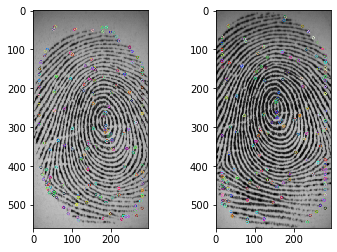

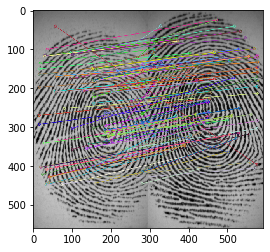

Fingerprint matches.  Score:  2672.0
Is the fingerprint a match? True


In [5]:
arg1="101_1.tif"#given input
arg2="101_2.tif" #template
match1=main(arg1,arg2)
print("Is the fingerprint a match?",match1) 

In [6]:
import speech_recognition as sr

match2=False
password="open car"
r = sr.Recognizer()
with sr.Microphone() as source:
    print("Speak")
    audio = r.listen(source)
try:
    txt = r.recognize_google(audio)
    print("You said:",txt)
except sr.UnknownValueError:
    print("Could not understand audio")
except sr.RequestError as e:
    print("Could not request results; {0}".format(e))
if txt!=password:
    print("Password Mismatch")
    match2=False
else:
    print("Password Match")
    match2=True

Speak
You said: open car
Password Match


In [9]:
def call_fingerprint():
    args1="103_4.tif" #given input
    args2=arg2 #template
    match3=main(args1,args2)
    print("Is the fingerprint a match?",match3)
    print("Car door Opens")
    return match3

In [10]:
print(match1,match2)

True True


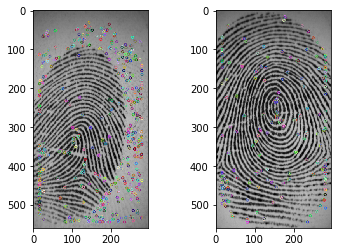

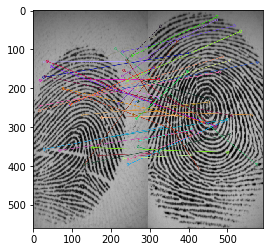

Fingerprint does not match.  Score:  2046.0
Is the fingerprint a match? False


In [12]:
# when both are false
import send_sms
finalmatch=False
if match1 and match2:
    finalmatch=call_fingerprint()
else:
    arg=arg2[:3]
    send_sms.sms(arg)
    finalmatch=False

In [13]:
if finalmatch:
    print("Car starts")
else:
    arg=arg2[:3]
    send_sms.sms(arg)

Message sent
